## Transform and dataloader

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

img_size = 224
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_data = datasets.ImageFolder("/kaggle/input/dataset-for-training-color-classifier/dataset/train", transform=transform)
val_data   = datasets.ImageFolder("/kaggle/input/dataset-for-training-color-classifier/dataset/val", transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)


## Prepare model

In [14]:
import torch.nn as nn
from torchvision import models

num_classes = 7
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Replace final FC layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs = 10


## Training process

In [ ]:
from tqdm import tqdm

def train_on_batch(model, x_batch, y_batch, optimizer, criterion):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    model.train()
    optimizer.zero_grad()

    output = model(x_batch)
    _, predicted = torch.max(output, 1)
    corr = (predicted == y_batch).sum().item()

    loss = criterion(output, y_batch)

    loss.backward()
    optimizer.step()
    return loss.cpu(), corr/len(y_batch)

def train_on_epoch(train_dataloader, optimizer, criterion, model):
    epoch_loss = 0.
    total = 0
    acc = 0.
    pbar = tqdm(train_dataloader)
    for (x_batch, y_batch) in pbar:
        batch_loss, corr = train_on_batch(model=model,
                                         x_batch=x_batch, y_batch=y_batch,
                                         optimizer=optimizer, criterion=criterion)
        pbar.set_description(f"loss: {batch_loss:.4f} acc: {corr:.4f}")

        epoch_loss += batch_loss * len(y_batch)
        total += len(x_batch)
        acc += corr*len(x_batch)
    return epoch_loss/total, acc/total

In [4]:
def test(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
    
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

In [15]:
train_losses = []
val_accuracies = []
for epoch in range(epochs):
    epoch_loss, acc = train_on_epoch(train_loader, optimizer, criterion, model)
    print(epoch, epoch_loss.item(), acc)

    correct = test(model, val_loader)
    print(f"{epoch} - Validation Accuracy: {100 * correct:.2f}%")

    train_losses.append(epoch_loss.item())
    val_accuracies.append(correct)
torch.save(model.state_dict(), "resnet18.pth")


loss: 0.1158 acc: 1.0000: 100%|██████████| 80/80 [00:12<00:00,  6.49it/s]


0 0.426654577255249 0.026883561643835617
0 - Validation Accuracy: 88.46%


loss: 0.1458 acc: 0.9630: 100%|██████████| 80/80 [00:12<00:00,  6.46it/s]


1 0.16396227478981018 0.02974333188374284
1 - Validation Accuracy: 92.11%


loss: 0.0347 acc: 1.0000: 100%|██████████| 80/80 [00:12<00:00,  6.59it/s]


2 0.1115262433886528 0.030124755381604695
2 - Validation Accuracy: 91.40%


loss: 0.1267 acc: 0.9630: 100%|██████████| 80/80 [00:12<00:00,  6.56it/s]


3 0.09674227237701416 0.030305954192940493
3 - Validation Accuracy: 94.94%


loss: 0.0996 acc: 0.9259: 100%|██████████| 80/80 [00:12<00:00,  6.62it/s]


4 0.0681397020816803 0.030646154961223453
4 - Validation Accuracy: 94.23%


loss: 0.0117 acc: 1.0000: 100%|██████████| 80/80 [00:12<00:00,  6.43it/s]


5 0.050164103507995605 0.030968688845401174
5 - Validation Accuracy: 94.46%


loss: 0.0424 acc: 0.9630: 100%|██████████| 80/80 [00:12<00:00,  6.60it/s]


6 0.050945382565259933 0.030734036384721317
6 - Validation Accuracy: 94.46%


loss: 0.0209 acc: 1.0000: 100%|██████████| 80/80 [00:12<00:00,  6.44it/s]


7 0.06809861212968826 0.03055283757338552
7 - Validation Accuracy: 92.93%


loss: 0.0018 acc: 1.0000:  52%|█████▎    | 42/80 [00:06<00:06,  6.32it/s]


KeyboardInterrupt: 

## Training results visualization

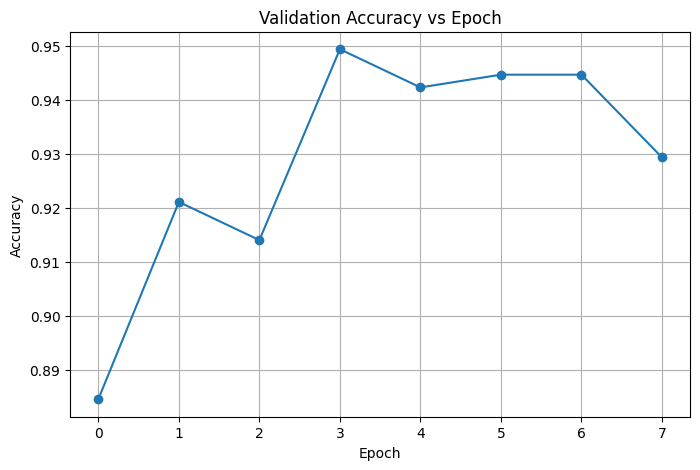

In [17]:
import matplotlib.pyplot as plt

# --- Plot Validation Accuracy vs Epoch ---
plt.figure(figsize=(8,5))
plt.plot(val_accuracies, marker='o')
plt.title("Validation Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# --- Plot Training Loss vs Epoch ---
plt.figure(figsize=(8,5))
plt.plot(train_losses, marker='o')
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()



In [ ]:
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 7)
model.load_state_dict(torch.load("resnet18.pth", map_location=device))
model.to(device)
model.eval()